##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1427]:
import torch as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [1428]:
orig_df = pd.read_csv('/kaggle/input/lvmpd-stats/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

df = pd.read_csv('/kaggle/input/lvmpd-stats/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [1429]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the incident.

## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 

In [1430]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


**X** represents the longitude of the incident.

**Y** represents the latitude of the incident.

**Area_Command** represents the administrative area in which the incident took place. 

**NIBRSOffenseCode** is a code that represents the type of crime committed.

**DayOfWeek** is simply the day of the week the incident occurred.

**Time** represents the time of day the incident occurred. 

**VictimCount** is the number of victims involved in an incident. 

The input variables are **X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek,** and **Time**.

Target variable is **VictimCount**. <br><br>

In [1431]:
print("Minimumn: ")
print(df.min())
print('\n')

print("Maximum: ")
print(df.max())
print('\n')

print("Range: ")
print(df.max() - df.min())

Minimumn: 
X                  -116.000000
Y                    35.068419
Area_Command          0.000000
NIBRSOffenseCode      0.000000
DayOfWeek             0.000000
Time                  0.000000
VictimCount           0.000000
dtype: float64


Maximum: 
X                  -114.62557
Y                    37.00000
Area_Command         11.00000
NIBRSOffenseCode      2.00000
DayOfWeek             6.00000
Time                 23.00000
VictimCount           6.00000
dtype: float64


Range: 
X                    1.374430
Y                    1.931581
Area_Command        11.000000
NIBRSOffenseCode     2.000000
DayOfWeek            6.000000
Time                23.000000
VictimCount          6.000000
dtype: float64


In [1432]:
scaler = MinMaxScaler()

df['X'] = scaler.fit_transform(df[['X']])
df['Y'] = scaler.fit_transform(df[['Y']])

Normalization is only required (or rather, recommended) for columns that contain continuous values, which in this case, are columns X and Y. Not to mention, these two columns consist entirely of negative values, which may reduce the accuracy of our model. Thus, it is in our best interest to normalize these columns.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [1433]:
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values
Y = df['VictimCount'].values

# Splitting data 80/20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

# Converting each array to tensor
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)

# Create TensorDatasets
datasetTrain = TensorDataset(X_train, Y_train)
datasetTest = TensorDataset(X_test, Y_test)

# Create DataLoaders using batch size of 64
trainLoader = DataLoader(datasetTrain, batch_size = 64)
testLoader = DataLoader(datasetTest, batch_size = 64)

# Display shape of data in each loader
print("Train: ")
for i, j in (trainLoader):
    print(i.shape, j.shape)
print('\n')

print("Test: ")
for k, l in (testLoader):
    print(k.shape, l.shape)

Train: 
torch.Size([64, 6]) torch.Size([64])
torch.Size([64, 6]) torch.Size([64])
torch.Size([64, 6]) torch.Size([64])
torch.Size([28, 6]) torch.Size([28])


Test: 
torch.Size([55, 6]) torch.Size([55])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [1434]:
# Defining proper loss function
funcLoss = torch.nn.MSELoss()

# Defining size of predicted output
sizeOutput = 1

# Defining model with 3 layers
inputSize = X_train.shape[1]
numberOfNeurons = 16

model = torch.nn.Sequential(
    torch.nn.Linear(inputSize, numberOfNeurons),
    torch.nn.ReLU(),
    torch.nn.Linear(numberOfNeurons, numberOfNeurons),
    torch.nn.ReLU(),
    torch.nn.Linear(numberOfNeurons, sizeOutput),
)

print(model)
print('\n')

# Defining optimizer with a learning rate of 0.001, the default value
# Adam optimizer is generally considered to be faster and easier to use than other algorithms
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 100

# Array to store MSE for each epoch
mseLog = []

# Training loop to iterate over a range of epochs
for e in range(epochs):
    
    model.train()
    
    for x, y in trainLoader:
        # Reset gradient of tensors
        optimizer.zero_grad()
        
        # Use model to predict Y
        Y_prediction = model(x)
        loss = funcLoss(Y_prediction, y)
        
        # Perform backwards pass and update weights
        loss.backward()
        optimizer.step()
        
    model.eval()
    
    # Disables gradient computation to reduce memory overuse
    with torch.no_grad():
        
        # For each epoch, we must keep track of test loss (cumulative)
        testLossTotal = 0.0
        
        for x, y in testLoader:
            Y_prediction = model(x)
            testLossTotal += funcLoss(Y_prediction, y)
            
    mseLog.append(testLossTotal)
    
    print("Epoch: ", e + 1, "MSE: ", testLossTotal.item())
    
print('\n')    
print("Lowest MSE: ", min(mseLog).item())

Sequential(
  (0): Linear(in_features=6, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


Epoch:  1 MSE:  1.6562974452972412
Epoch:  2 MSE:  1.394148349761963
Epoch:  3 MSE:  1.238304853439331
Epoch:  4 MSE:  1.1277039051055908
Epoch:  5 MSE:  1.0368825197219849
Epoch:  6 MSE:  0.953888475894928
Epoch:  7 MSE:  0.8489989638328552
Epoch:  8 MSE:  0.7353613376617432
Epoch:  9 MSE:  0.6494371294975281
Epoch:  10 MSE:  0.6068235635757446
Epoch:  11 MSE:  0.6097370982170105
Epoch:  12 MSE:  0.6393441557884216
Epoch:  13 MSE:  0.6631693840026855
Epoch:  14 MSE:  0.6623688340187073
Epoch:  15 MSE:  0.6438431143760681
Epoch:  16 MSE:  0.6225454211235046
Epoch:  17 MSE:  0.6067541241645813
Epoch:  18 MSE:  0.5974149107933044
Epoch:  19 MSE:  0.5925650000572205
Epoch:  20 MSE:  0.5904918909072876
Epoch:  21 MSE:  0.5903388261795044
Epoch:  22 MSE:  0.591452956199646
Epoch

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch:  30 MSE:  0.5787351131439209
Epoch:  31 MSE:  0.5772313475608826
Epoch:  32 MSE:  0.576080858707428
Epoch:  33 MSE:  0.575012743473053
Epoch:  34 MSE:  0.5738120079040527
Epoch:  35 MSE:  0.5723956227302551
Epoch:  36 MSE:  0.5708222389221191
Epoch:  37 MSE:  0.5692035555839539
Epoch:  38 MSE:  0.5676649808883667
Epoch:  39 MSE:  0.5662775635719299
Epoch:  40 MSE:  0.5650282502174377
Epoch:  41 MSE:  0.5638839602470398
Epoch:  42 MSE:  0.5627970099449158
Epoch:  43 MSE:  0.561728298664093
Epoch:  44 MSE:  0.5606598854064941
Epoch:  45 MSE:  0.5596005320549011
Epoch:  46 MSE:  0.5585699081420898
Epoch:  47 MSE:  0.5575885772705078
Epoch:  48 MSE:  0.5566741228103638
Epoch:  49 MSE:  0.5558979511260986
Epoch:  50 MSE:  0.555176854133606
Epoch:  51 MSE:  0.5544765591621399
Epoch:  52 MSE:  0.553761899471283
Epoch:  53 MSE:  0.5530350804328918
Epoch:  54 MSE:  0.5523767471313477
Epoch:  55 MSE:  0.5517879724502563
Epoch:  56 MSE:  0.5512374043464661
Epoch:  57 MSE:  0.55070263147354

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [1435]:
# Defining proper loss function
funcLoss = torch.nn.CrossEntropyLoss()

# Defining size of output
# The number of classes corresponds to the range of values in the column VictimCount
# A given crime may have 0 to 6 victims, or 7 unique values.
sizeOutput = 7

inputSize = X_train.shape[1]

# Defining model with 4 layers
# This model's architecture has an additional layer
# Two layers will use 64 neurons
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, sizeOutput),
)

# Defining Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 100

accuracyLog = []

for e in range(epochs):
    model.train()
    
    for i, data in enumerate(trainLoader):
        # Must unpack data and make appropriate conversions
        inputs, labels = data
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.long)
        
        # Reset tensor gradient
        optimizer.zero_grad()
        
        # Use model to predict Y
        Y_prediction = model(inputs)
        loss = funcLoss(Y_prediction, labels)
        
        # Perform backwards pass and update weights 
        loss.backward()
        optimizer.step()

    # Variables that will be used to calculate accuracy
    numberCorrect = 0
    totalSamples = 0
        
    model.eval()
    
    # Disable gradient computation
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            # Unpack data and make appropriate conversions
            inputs, labels = data
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.long)

            # Use model to predict Y
            Y_prediction = model(inputs)
            
            # Obtain the maximum value of output
            _, predictions = torch.max(Y_prediction, 1)
            
            # Increment if prediction is correct
            numberCorrect += (predictions == labels).sum().item()
            
            totalSamples += predictions.size(0)
            
        accuracy = numberCorrect / totalSamples
        accuracyLog.append(accuracy)

    print("Epoch: ", e + 1, "Accuracy {:.2f} %".format(accuracy * 100))

print('\n')
print("Highest accuracy: ", max(accuracyLog) * 100, "%")

Epoch:  1 Accuracy 34.55 %
Epoch:  2 Accuracy 38.18 %
Epoch:  3 Accuracy 36.36 %
Epoch:  4 Accuracy 38.18 %
Epoch:  5 Accuracy 41.82 %
Epoch:  6 Accuracy 38.18 %
Epoch:  7 Accuracy 38.18 %
Epoch:  8 Accuracy 41.82 %
Epoch:  9 Accuracy 41.82 %
Epoch:  10 Accuracy 41.82 %
Epoch:  11 Accuracy 40.00 %
Epoch:  12 Accuracy 41.82 %
Epoch:  13 Accuracy 40.00 %
Epoch:  14 Accuracy 41.82 %
Epoch:  15 Accuracy 41.82 %
Epoch:  16 Accuracy 45.45 %
Epoch:  17 Accuracy 43.64 %
Epoch:  18 Accuracy 43.64 %
Epoch:  19 Accuracy 45.45 %
Epoch:  20 Accuracy 45.45 %
Epoch:  21 Accuracy 49.09 %
Epoch:  22 Accuracy 49.09 %
Epoch:  23 Accuracy 49.09 %
Epoch:  24 Accuracy 49.09 %
Epoch:  25 Accuracy 49.09 %
Epoch:  26 Accuracy 49.09 %
Epoch:  27 Accuracy 49.09 %
Epoch:  28 Accuracy 49.09 %
Epoch:  29 Accuracy 49.09 %
Epoch:  30 Accuracy 49.09 %
Epoch:  31 Accuracy 49.09 %
Epoch:  32 Accuracy 49.09 %
Epoch:  33 Accuracy 49.09 %
Epoch:  34 Accuracy 49.09 %
Epoch:  35 Accuracy 49.09 %
Epoch:  36 Accuracy 49.09 %
E

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Tasks 3 and 4 took quite some time to complete. I spent quite a bit of time referring to PyTorch's documentation. It is hard for me to say with certainty which model is superior because each model uses a different metric of evaluation. However, I am inclined to say that our regression model is better. The lowest MSE it achieved was 0.5425. On the other hand, classification yielded a maximum accuracy of 49.09%, which sounds much less impressive.

I was unable to complete the second portion of this task.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


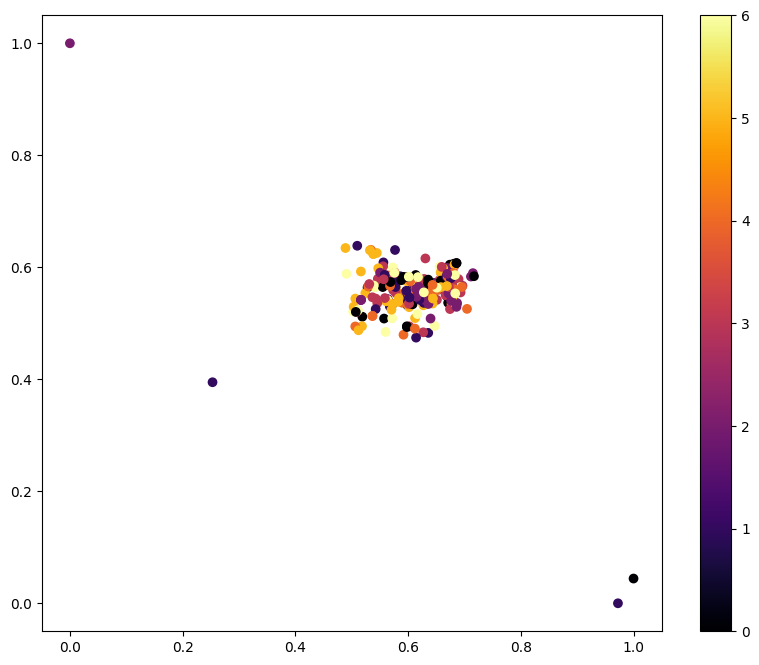

In [1436]:
X_coordinates = df['X']
Y_coordinates = df['Y']

dates = df['DayOfWeek']

plt.figure(figsize = (10, 8))
p = plt.scatter(X_coordinates, Y_coordinates, c = dates, cmap = 'inferno')
plt.colorbar(p)

plt.show()

There is no easily discernible pattern in this plot, other than that the vast majority of crimes occur in a relatively specific part of Las Vegas. No particular color stands out to me, at least not at first glance.

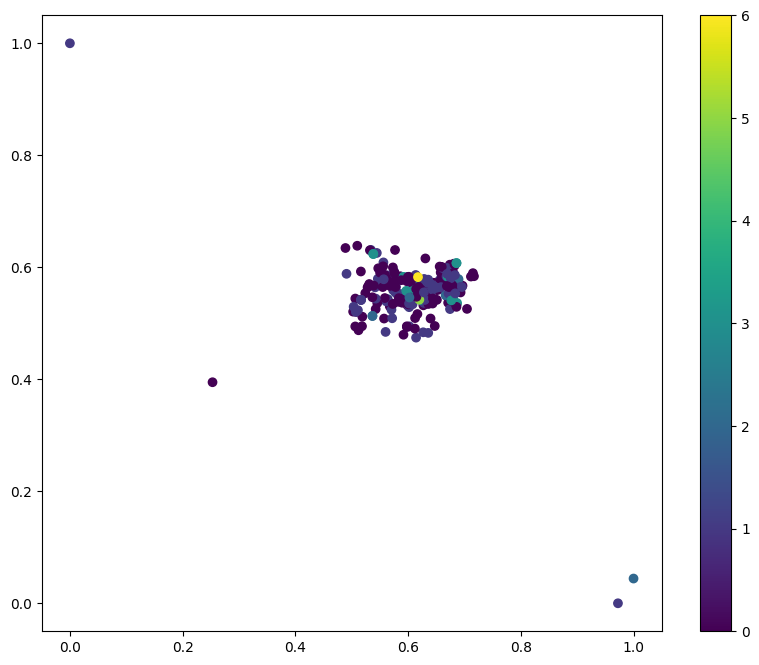

In [1437]:
numVictims = df['VictimCount']

plt.figure(figsize = (10, 8))
p = plt.scatter(X_coordinates, Y_coordinates, c = numVictims, cmap = 'viridis')
plt.colorbar(p)

plt.show()

This plot is almost identical to the previous one. However, it is clear that most crimes are colored with the lower end of the legend, indicating that the majority of crimes have a victim count that is likely to be less than 3.

In [1438]:
sortedDates = df['DayOfWeek'].sort_values(ascending = False)
sortedGroupedDates = sortedDates.value_counts()

print(sortedGroupedDates)

DayOfWeek
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: count, dtype: int64


The indices our dataset uses to represent days of the week are not ordered sequentially, surprisingly.

Meaning that 0 does not represent Sunday, nor does 6 represent Saturday.

The most frequent day in which crimes occur appears to be Sunday, followed by Saturday and Monday.